**TODO**
* Add custom sort to configparser
* ✅ Use pixel scale to scale the dx and dys
* Fix offset correction. Turned off for now.
* The indices are not ordered by time!!!!

### Init

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import logging

from astropy.table import Table
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from lmfit import fit_report
import numpy as np
import matplotlib.pyplot as plt

from gaussian_model import SingleGaussian, DoubleGaussian
from image import Image
from util.editor import Editor

#### Config ####
constants = Editor('res/constants.ini')
data_folder = 'res/images'
min_distance = 50 # minimum distance between stars to perform Gaussian
dates = {'4-25-2021': [f'_{x}' for x in 'V'],
         '5-13-2021': [f'_{x}' for x in 'V'],
         '5-17-2021': [f'_{x}' for x in 'V'], # 5-19-2021 is bad
         '5-24-2022': [f'_{x}' for x in 'V'],
         '6-9-2022': [f'_{x}' for x in 'ABCDEFGHJK'], 
         '7-7-2022': [f'_{x}' for x in 'ABCDEFGHI']}

#### Logging ####
log = logging.getLogger('psfphot')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger('parso.python.diff').disabled = True # turn off IPython debugging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

verbose=False
logging.getLogger('image').setLevel(logging.DEBUG if verbose else logging.INFO)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:editor:Set up io for res/constants.ini
INFO:editor:Reloading io


In [65]:
def calc_offset(image):
    """
    Determine offset angle from north of camera image by averaging 4 angles of square
    """
    WCSULRA = image.get_image_hdu_value('WCSULRA')
    WCSULDEC = image.get_image_hdu_value('WCSULDEC')
    WCSURRA = image.get_image_hdu_value('WCSURRA')
    WCSURDEC = image.get_image_hdu_value('WCSURDEC')
    WCSLLRA = image.get_image_hdu_value('WCSLLRA')
    WCSLLDEC = image.get_image_hdu_value('WCSLLDEC')
    WCSLRRA = image.get_image_hdu_value('WCSLRRA')
    WCSLRDEC = image.get_image_hdu_value('WCSLRDEC')

    ul = (WCSULRA, WCSULDEC)
    ur = (WCSURRA, WCSURDEC)
    ll = (WCSLLRA, WCSLLDEC)
    lr = (WCSLRRA, WCSLRDEC)

    delta1 = np.subtract(ur, ul) * 3600 / .34
    delta2 = np.subtract(lr, ll) * 3600 / .34
    delta3 = np.subtract(ul, ll) * 3600 / .34
    delta4 = np.subtract(ur, lr) * 3600 / .34
    
    return (np.mean([-1 * np.arctan(delta1[1]/delta1[0]) * 180/np.pi,
            -1 * np.arctan(delta2[1]/delta2[0]) * 180/np.pi,
            90 - np.arctan(delta3[1]/delta3[0]) * 180/np.pi,
            90 - np.arctan(delta4[1]/delta4[0]) * 180/np.pi]))

In [69]:
# Set up constants.ini
for date in dates:
    log.info(date)
    indices = dates[date]
    if not constants.has_section(f'{date}'):
        constants.add_section(f'{date}')

    # Get header info
    for index in indices:
        if not constants.has_section(f'{date}{index}'):
            constants.add_section(f'{date}{index}')
        fn = f'{data_folder}/{date}/pluto{index}'
        image = Image(fn)
        constants.set(f'{date}{index}', 'obs_time',  image.get_image_hdu_value('DATE-OBS'))
        try:
            constants.set(f'{date}{index}', 'offset',  calc_offset(image))
        except TypeError:
            pass
        
        if index == indices[0]:
            constants.set(f'{date}', 'start', constants.get(f'{date}{index}', 'obs_time'))
            constants.set(f'{date}', 'pix_scale_x', image.get_image_hdu_value('CDELT2'))
            constants.set(f'{date}', 'pix_scale_y', image.get_image_hdu_value('CDELT1'))
            constants.set(f'{date}', 'subimage_dim', int(60 * .34 / constants.get(f'{date}', 'pix_scale_x', type='float')))
            constants.set(f'{date}', 'north_up', image.get_image_hdu_value('NORTH-UP'))
        if index == indices[-1]:
            constants.set(f'{date}', 'end', constants.get(f'{date}{index}', 'obs_time'))

    # Query apparent magnitude from JPL Horizons ephemeris
    pluto = Horizons(id=999, location=792, epochs=Time(constants.get(date, 'start')).jd).ephemerides()
    pluto_vmag = pluto['V'][0]
    constants.set(date, 'pluto_vmag', pluto_vmag)
    charon = Horizons(id='Charon', location=792, epochs=Time(constants.get(date, 'start')).jd).ephemerides()
    charon_vmag = charon['V'][0]
    constants.set(date, 'charon_vmag', charon_vmag)
    constants.set(date, 'rel_flux', 10**-((charon_vmag-pluto_vmag)/2.5))
    invert = 1 if constants.get(date, 'north_up', 'bool') else -1
    constants.set(date, 'dx_guess', invert * (charon['RA'][0] - pluto['RA'][0])*3600 / constants.get(date, 'pix_scale_x', 'float'))
    constants.set(date, 'dy_guess', invert * (charon['DEC'][0] - pluto['DEC'][0])*3600 / constants.get(date, 'pix_scale_y', 'float'))
    """
    When north-up is true, x increases with increasing RA and y increases with increasing DEC
    When north-up is false, x decreases with increasing RA and y decreases with increasing DEC
    """

INFO:psfphot:4-25-2021
INFO:psfphot:5-13-2021
INFO:psfphot:5-17-2021
INFO:psfphot:5-24-2022
INFO:psfphot:6-9-2022
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
INFO:image:ERROR: Keyword  + str(name) +  not found
IN

### Analyze star nearby Pluto and Charon to estimate $\sigma_x$, $\sigma_y$, and $\theta$

In [14]:
constants.reload()
used_dates = dates.keys()
for date in used_dates:
    indices = dates[date]
    dim = constants.get(date, 'subimage_dim', 'int') # n by n dimension of subimage
    for index in indices:
        entry = constants.get_section(f'{date}{index}')
        log.info(f'{date}{index}')
        path = f'{data_folder}/{date}/pluto{index}.fits'
        image = Image(path).subimage(entry['ref_star_x'], entry['ref_star_y'], dim, dim)
        image.write_fits(f'res/images/{date}/refstar{index}.fits')
        psfinit = {}
        psfinit['a'] = 500
        psfinit['bg'] = 500
        psfinit['xc'] =  dim/2
        psfinit['yc'] = dim/2
        psfinit['theta'] = 0
        psfinit['sigma_x'] = 5
        psfinit['sigma_y'] = 5

        psf = SingleGaussian(psfinit, image)
        psf.set_vary(['a', 'bg', 'xc', 'yc', 'theta', 'sigma_x', 'sigma_y'])
        psf.set_limits('a', 100, 100000)
        psf.set_limits('bg', 100, 10000)
        psf.set_limits('xc', 0, dim)
        psf.set_limits('yc', 0, dim)
        psf.set_limits('sigma_x', 0, 50)
        psf.set_limits('sigma_y', 0, 50)
        params = psf.run_minimizer()
        log.info(psf.get_result())
        log.info(fit_report(params, show_correl=False))

        entry['sigma_x'] = str(params['sigma_x'].value)
        entry['sigma_y'] = str(params['sigma_y'].value)
        entry['theta'] = str(params['theta'].value*180/np.pi % 360)
        constants.save()
        


INFO:editor:Reloading io
INFO:psfphot:4-25-2021_V
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a:        2110.37464 +/- 29.7291573 (1.41%) (init = 500)
    bg:       4371.16602 +/- 3.95050802 (0.09%) (init = 500)
    xc:       7.41264195 +/- 0.02117106 (0.29%) (init = 8.5)
    yc:       7.85976254 +/- 0.02392850 (0.30%) (init = 8.5)
    theta:   -1.17577175 +/- 0.05667813 (4.82%) (init = 0)
    sigma_x:  1.73698576 +/- 0.02531855 (1.46%) (init = 5)
    sigma_y:  1.45833421 +/- 0.02125691 (1.46%) (init = 5)
INFO:psfphot:5-13-2021_V
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a:        3740.75744 +/- 30.5054365 (0.82%) (init = 500)
    bg:       2763.43036 +/- 4.88345373 (0.18%) (init = 500)
    xc:       7.17747273 +/- 0.01445867 (0.20%) (init = 8.5)
    yc:       7.82002563 +/- 0.01538821 (0.20%) (init = 8.5)
    theta:   -12.3404592 +/- 0.08316847 (0.67%) (init = 0)
    sigma_x:  1.76643413 +/- 0.0151

### Use above values to fit Pluto and Charon psf

In [15]:
constants.reload()
used_dates = dates.keys()# ['6-9-2022']
for date in used_dates:
    indices = dates[date]
    dim = constants.get(date, 'subimage_dim', 'int') # n by n dimension of subimage
    for index in indices:
        log.info(f'{date}{index}')
        path = f'{data_folder}/{date}/pluto{index}.fits'
        entry = constants.get_section(f'{date}{index}')
        image = Image(path).subimage(entry['pluto_charon_x'], entry['pluto_charon_y'], dim, dim)
        image.write_fits(f'res/images/{date}/pluto_charon{index}.fits')
        psfinit = {}
        psfinit['a_p'] = 250
        psfinit['rel_flux'] = constants.get(f'{date}', f'rel_flux', 'float')
        psfinit['bg'] = 500
        psfinit['x_p'] =  dim/2
        psfinit['y_p'] = dim/2
        psfinit['dx'] = constants.get(f'{date}', f'dx_guess', 'float')
        psfinit['dy'] = constants.get(f'{date}', f'dy_guess', 'float')
        psfinit['theta'] = float(entry['theta']) * np.pi/180
        psfinit['sigma_x'] = float(entry['sigma_x'])
        psfinit['sigma_y'] = float(entry['sigma_y'])

        psf = DoubleGaussian(psfinit, image)
        psf.set_vary(['a_p', 'bg', 'x_p', 'y_p', 'dx', 'dy'])
        psf.set_limits('a_p', 100, 100000)
        psf.set_limits('bg', 100, 10000)
        psf.set_limits('x_p', 0, dim)
        psf.set_limits('y_p', 0, dim)
        limit = 8.5 * .34 / constants.get(f'{date}', f'pix_scale_x', 'float')
        psf.set_limits('dx', -limit, limit)
        psf.set_limits('dy', -limit, limit)
        params = psf.run_minimizer()
        log.info(psf.get_result())
        log.info(fit_report(params, show_correl=False))

        entry['dx'] = str(params['dx'].value)
        entry['dy'] = str(params['dy'].value)
        constants.save()


INFO:editor:Reloading io
INFO:psfphot:4-25-2021_V
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a_p:       1257.61456 +/- 22.7025467 (1.81%) (init = 250)
    rel_flux:  0.185012 (fixed)
    bg:        4350.76268 +/- 3.64271353 (0.08%) (init = 500)
    x_p:       9.86532041 +/- 784.545437 (7952.56%) (init = 8.5)
    y_p:       9.84547282 +/- 656.895152 (6672.05%) (init = 8.5)
    dx:       -1.7987e-05 +/- 5025.05599 (27936574335.75%) (init = 0.1574748)
    dy:        1.0193e-04 +/- 4207.44893 (4127715674.16%) (init = 0.5669093)
    theta:     5.107414 (fixed)
    sigma_x:   1.736986 (fixed)
    sigma_y:   1.458334 (fixed)
INFO:psfphot:5-13-2021_V
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a_p:       888.953472 +/- 17.3440291 (1.95%) (init = 250)
    rel_flux:  0.1839924 (fixed)
    bg:        2733.59271 +/- 3.14792239 (0.12%) (init = 500)
    x_p:       6.48894009 +/- 0.06024277 (0.93%) (init = 8.5)
   

### Plot pluto and charon results

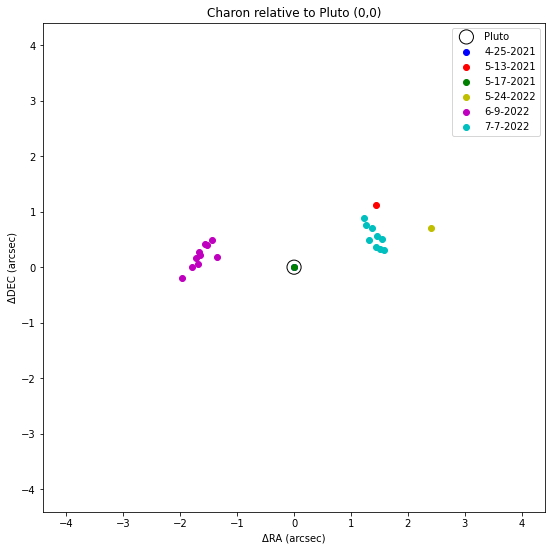

In [16]:
def apply_offset(dx, dy, theta):
    # Calculate dx' and dy' in a coordinate frame rotated by theta clockwise
    return (dx * np.cos(theta) - dy * np.sin(theta), dx * np.sin(theta) + dy * np.cos(theta))

do_offset_correction = False

colors = ['b', 'r', 'g', 'y', 'm', 'c']
lim = 0

dxs = []
dys = []
for date in dates:
    indices = dates[date]
    invert = 1 if constants.get(date, 'north_up', 'bool') else -1
    dxs_date = []
    dys_date = []
    for index in indices:
        dx = invert * constants.get(f'{date}{index}', f'dx', 'float') * constants.get(f'{date}', f'pix_scale_x', 'float')
        dy = invert * constants.get(f'{date}{index}', f'dy', 'float') * constants.get(f'{date}', f'pix_scale_y', 'float')
        
        if do_offset_correction:
            if constants.has(f'{date}{index}', 'offset'):
                offset = constants.get(f'{date}{index}', 'offset', 'float') * np.pi/180 * invert
                dx, dy = apply_offset(dx, dy ,offset)
        dxs_date.append(dx)
        dys_date.append(dy)
        lim = max(lim, max(dx, dy)) + 0.1
    dxs.append(dxs_date)
    dys.append(dys_date)

plt.figure(figsize=(9,9))
plt.title(f'Charon relative to Pluto (0,0)')
plt.xlim(-1*lim, lim)
plt.ylim(-1*lim, lim)
plt.xlabel('ΔRA (arcsec)')
plt.ylabel('ΔDEC (arcsec)')
i = 0
plt.scatter([0], [0], s=200,facecolors='none', edgecolors='k', marker='o', label='Pluto')
for dx, dy in zip(dxs, dys):
    plt.scatter(dx, dy, c=colors[i], label=list(dates.keys())[i])
    i += 1
plt.legend()
plt.savefig(f'{os.path.expanduser("~")}/Downloads/plutocharon.png')
plt.show()

Determine orbital period
1. Calculate angle associated with each data point
2. Fit average angular speed
3. Refine estimate based on spacing between two datasets

In [31]:
do_offset_correction = False

used_dates =['6-9-2022', '7-7-2022']
thetas = []

for date in used_dates:
    indices = dates[date]
    invert = 1 if constants.get(date, 'north_up', 'bool') else -1
    thetas_date = []
    for index in indices:
        dx = invert * constants.get(f'{date}{index}', f'dx', 'float') * constants.get(f'{date}', f'pix_scale_x', 'float')
        dy = invert * constants.get(f'{date}{index}', f'dy', 'float') * constants.get(f'{date}', f'pix_scale_y', 'float')
        
        if do_offset_correction:
            pass
        theta = np.arctan2(dy, dx) * 180/np.pi
        while theta < 0:
            theta += 360
        print(constants.get(f'{date}{index}', f'obs_time'), theta)
        thetas_date.append(theta)
        
    thetas.append(thetas_date)

print(thetas)


[[160.96238826768843, 165.08893588512268, 172.18893677489433, 170.52759966178695, 174.4274555465674, 180.1299706927803, 178.19039970863128, 185.44371679366378, 172.46713780326817, 164.88811608702835], [18.31872238503065, 13.913831816230648, 11.105492526763788, 20.80033740169547, 20.327742886080692, 30.863363093403088, 27.438508541600516, 35.95174615111865, 12.28147929343801]]
28.033240740653127
0
0.03166666626930237
172.43146572214314
0.46566099731283545
1
0.11731481458991766
21.222358232817946
1.6997867723193607
